# Step 1: Importing Required Libraries


In [1]:
# Basic libraries for data manipulation
import numpy as np
import pandas as pd

# Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Machine Learning and Deep Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dropout, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Step 2: Load the Dataset


In [4]:

# Load the dataset (assuming 'Bitcoin_tweets.csv' is available in the working directory)
df = pd.read_csv('C:/Users/HP/crypto-tweet-analysis/data/Bitcoin_tweets.csv')
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Drop rows with missing values if any
df.dropna(inplace=True)


   id        date                                               text  \
0   2  2018-03-23  RT @tippereconomy: Another use case for #block...   
1   3  2018-03-23                 free coins https://t.co/DiuoePJdap   
2   4  2018-03-23  RT @payvxofficial: WE are happy to announce th...   
3   5  2018-03-23  Copy successful traders automatically with Bit...   
4   6  2018-03-23  RT @bethereumteam: We're revealing our surpris...   

       Screen_name                                             Source  \
0     hojachotopur       [u'blockchain', u'Tipper', u'TipperEconomy']   
1    denies_distro                                                 []   
2       aditzgraha                                                 []   
3  VictorS61164810                                                 []   
4      ClarkKalel4  [u'surprise', u'presents', u'crypto', u'bitcoin']   

                                                Link     Sentiment  \
0  <a href="http://twitter.com" rel="nofollow">Tw...  ['po

# Step 3: Data Preprocessing (Tokenization, Lemmatization, Stop Words Removal)


In [7]:

# Initialize preprocessing tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to preprocess the text
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    
    # Remove stopwords and lemmatize
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    
    return ' '.join(filtered_tokens)

# Apply the preprocessing to the tweet column
df['cleaned_text'] = df['text'].apply(preprocess_text)

print(df['cleaned_text'].head())


0    rt tippereconomy another use case blockchain t...
1                                       free coin http
2    rt payvxofficial happy announce payvx presale ...
3    copy successful trader automatically bitcoin c...
4    rt bethereumteam revealing surprise tomorrow r...
Name: cleaned_text, dtype: object


In [9]:

# Step 4: Emotion Detection (Custom)
# Defining keywords associated with different emotions for a simple keyword-based emotion detection

emotion_keywords = {
    'happy': ['happy', 'joy', 'pleased', 'glad', 'delight', 'smile', 'excited'],
    'sad': ['sad', 'unhappy', 'sorrow', 'down', 'cry', 'depressed', 'upset'],
    'anger': ['angry', 'mad', 'furious', 'rage', 'annoyed', 'irritated'],
    'surprise': ['surprise', 'shocked', 'amazed', 'astonished'],
    'fear': ['fear', 'afraid', 'scared', 'terrified']
}

# Function to classify the emotion based on the presence of keywords in the tweet text
def classify_emotion(text):
    for emotion, keywords in emotion_keywords.items():
        if any(keyword in text.lower() for keyword in keywords):
            return emotion
    return 'neutral'  # Return neutral if no emotion keywords are found

# Apply the function to the 'cleaned_text' column of the dataset
df['Emotion'] = df['cleaned_text'].apply(lambda x: classify_emotion(x))

# Display the first few rows of the dataset with the new 'Emotion' column
print(df[['cleaned_text', 'Emotion']].head())


                                        cleaned_text  Emotion
0  rt tippereconomy another use case blockchain t...  neutral
1                                     free coin http  neutral
2  rt payvxofficial happy announce payvx presale ...    happy
3  copy successful trader automatically bitcoin c...  neutral
4  rt bethereumteam revealing surprise tomorrow r...      sad


In [11]:
from textblob import TextBlob
# Step 5: Mapping Emotions to Sentiments
# We will map the detected emotions to positive, negative, and neutral sentiments based on predefined rules.

def map_emotion_to_sentiment(emotion):
    if emotion in ['happy', 'surprise']:
        return 'positive'
    elif emotion in ['sad', 'anger', 'fear']:
        return 'negative'
    else:
        return 'neutral'

# Apply the mapping function to the 'Emotion' column to generate a new 'Mapped_Sentiment' column
df['sentiment'] = df['Emotion'].apply(lambda x: map_emotion_to_sentiment(x))

# Display the first few rows of the dataset with the new 'Mapped_Sentiment' column
print(df[['cleaned_text', 'Emotion', 'sentiment']].head())


                                        cleaned_text  Emotion sentiment
0  rt tippereconomy another use case blockchain t...  neutral   neutral
1                                     free coin http  neutral   neutral
2  rt payvxofficial happy announce payvx presale ...    happy  positive
3  copy successful trader automatically bitcoin c...  neutral   neutral
4  rt bethereumteam revealing surprise tomorrow r...      sad  negative


In [13]:
import pickle

# Tokenize the words and convert them to sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_text'])

# Save the tokenizer to a file
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

X = tokenizer.texts_to_sequences(df['cleaned_text'])
X = pad_sequences(X, maxlen=100)  # Padding sequences to have the same length

# Encode the target variable (emotion or sentiment column)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['sentiment'])

# Convert labels to categorical (one-hot encoding)
y = pd.get_dummies(df['sentiment']).values


# Step 5: Train-Test Split


In [16]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Step 6: Build the LSTM-GRU Hybrid Model


In [19]:
# Step 1: Preprocess the text data
max_sequence_length = 50  # Reduced sequence length to save memory
embedding_dim = 100  # Embedding dimension
num_classes = 3  # Adjust according to your number of classes

# Limit the vocabulary size to reduce memory usage
max_words = 10000  # Limit the number of words to the 10,000 most frequent
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['text'])  # Assuming 'df' is your DataFrame with a 'text' column

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['text'])

# Padding sequences to ensure equal length
X = pad_sequences(sequences, maxlen=max_sequence_length)

# Get vocabulary size for the embedding layer
vocab_size = max_words  # Set the vocabulary size to the max_words used in the tokenizer

# Step 2: Define the model architecture
model = Sequential()

# Add the Embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

# Add the LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(max_sequence_length, embedding_dim)))  # Pass input_shape

# Add Dropout for regularization
model.add(Dropout(0.2))

# Add GRU layer
model.add(GRU(units=32))

# Add Dense layer
model.add(Dense(32, activation='relu'))

# Final Dense layer for output
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 3: Display the model summary
model.build(input_shape=(None, max_sequence_length))  # Explicitly building with input shape
model.summary()


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 50, 100)             │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 50, 64)              │          42,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,052,803 (4.02 MB)

 Trainable params: 1,052,803 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

# Step 7: Model Training


In [21]:

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/10
848/848 ━━━━━━━━━━━━━━━━━━━━ 135s 142ms/step - accuracy: 0.9001 - loss: 0.2923 - val_accuracy: 0.9866 - val_loss: 0.0512
Epoch 2/10
848/848 ━━━━━━━━━━━━━━━━━━━━ 117s 137ms/step - accuracy: 0.9887 - loss: 0.0448 - val_accuracy: 0.9894 - val_loss: 0.0469
Epoch 3/10
848/848 ━━━━━━━━━━━━━━━━━━━━ 174s 205ms/step - accuracy: 0.9917 - loss: 0.0313 - val_accuracy: 0.9904 - val_loss: 0.0437
Epoch 4/10
848/848 ━━━━━━━━━━━━━━━━━━━━ 187s 221ms/step - accuracy: 0.9926 - loss: 0.0255 - val_accuracy: 0.9905 - val_loss: 0.0437
Epoch 5/10
848/848 ━━━━━━━━━━━━━━━━━━━━ 127s 149ms/step - accuracy: 0.9936 - loss: 0.0206 - val_accuracy: 0.9907 - val_loss: 0.0468
Epoch 6/10
848/848 ━━━━━━━━━━━━━━━━━━━━ 155s 183ms/step - accuracy: 0.9943 - loss: 0.0181 - val_accuracy: 0.9876 - val_loss: 0.0562
Epoch 7/10
848/848 ━━━━━━━━━━━━━━━━━━━━ 187s 220ms/step - accuracy: 0.9945 - loss: 0.0177 - val_accuracy: 0.9909 - val_loss: 0.0509
Epoch 8/10
848/848 ━━━━━━━━━━━━━━━━━━━━ 201s 237ms/step - accuracy: 0.9954 -

# Step 8: Evaluate the Model


424/424 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.9926 - loss: 0.0412
Test Accuracy: 0.9916


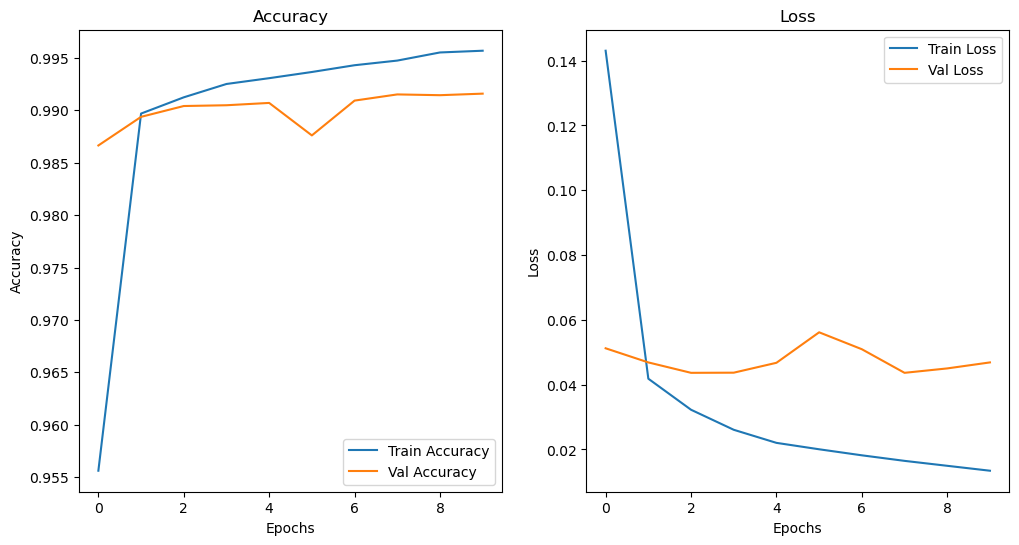

In [26]:

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

# Plot accuracy and loss curves
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Step 9: Save the Model


In [28]:

# Save the trained model
model.save('lstm_gru_cryptocurrency_tweet_model.h5')


# Step 10: Predict and Visualize Results


424/424 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step
              precision    recall  f1-score   support

    negative       0.99      0.97      0.98      3177
     neutral       0.99      1.00      0.99     10185
    positive       0.99      0.98      0.99       192

    accuracy                           0.99     13554
   macro avg       0.99      0.98      0.99     13554
weighted avg       0.99      0.99      0.99     13554



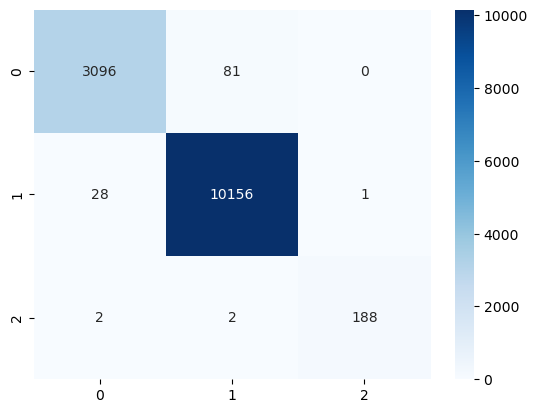

In [32]:

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))
